Automatic Annotation of New Faulty Images

In [ ]:
import os
import json
import cv2
import numpy as np
import torch
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from tqdm import tqdm
import glob
import datetime
import shutil
import random
import sys
import time

# Fixed parameters instead of interactive inputs
new_images_dir = "/home/pauloarbu/Faulty_without_annot/selected"  # Directory containing new faulty images
#model_dir = ./output/blade_defect_model_20250404_124113/model_final_state_dict.pth
model_dir = "./output/blade_defect_model_20250404_124113"
threshold = 0.5  # Detection threshold
extend_existing = False  # Whether to extend existing COCO annotations
existing_coco_path = None  # Path to existing COCO annotations
visualize = True  # Whether to visualize annotations

# Configure these variables directly in the notebook
# Change these values as needed rather than using input()
# CONFIGURATION PARAMETERS:
# ------------------------
# Set to True to extend an existing COCO file
EXTEND_EXISTING = True #False
# Path to existing COCO file if extending
EXISTING_COCO_PATH = None
# ------------------------


def load_model(model_dir, threshold=0.5):
    """Load a trained model from the specified directory"""
    if not os.path.exists(model_dir):
        raise ValueError(f"Model directory {model_dir} does not exist")
        
    print(f"Loading model from {model_dir}")
    
    # Create config
    cfg = get_cfg()
    
    # Try to load saved config
    config_file = os.path.join(model_dir, "config.yaml")
    if os.path.exists(config_file):
        cfg.merge_from_file(config_file)
    else:
        from detectron2 import model_zoo
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        
    # Set inference threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    
    # Find model weights
    model_options = [
        os.path.join(model_dir, "model_final.pth"),
        os.path.join(model_dir, "model_final_state_dict.pth")
    ]
    
    # Check for any checkpoint
    if not any(os.path.exists(m) for m in model_options):
        checkpoints = [f for f in os.listdir(model_dir) if f.startswith("model_") and f.endswith(".pth")]
        if checkpoints:
            model_options.append(os.path.join(model_dir, sorted(checkpoints)[-1]))
    
    # Set model weights
    for model_path in model_options:
        if os.path.exists(model_path):
            if model_path.endswith("state_dict.pth"):
                # Handle state dict format
                temp_path = os.path.join(model_dir, "converted_model.pth")
                model_state = torch.load(model_path, map_location=torch.device('cpu'))
                torch.save({"model": model_state}, temp_path)
                cfg.MODEL.WEIGHTS = temp_path
            else:
                cfg.MODEL.WEIGHTS = model_path
            break
    else:
        raise ValueError(f"No model weights found in {model_dir}")
    
    # Set device
    if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
    else:
        cfg.MODEL.DEVICE = "cpu"
    
    # Create predictor
    predictor = DefaultPredictor(cfg)
    
    return predictor, cfg

def auto_annotate_images(predictor, input_dir, output_coco_path, existing_coco_path=None, threshold=0.5, visualize=True):
    """
    Automatically annotate images in input_dir and save annotations in COCO format
    
    Args:
        predictor: Detectron2 predictor loaded with your model
        input_dir: Directory containing new faulty images to annotate
        output_coco_path: Path to save the new COCO annotations
        existing_coco_path: Optional path to existing COCO annotations to extend
        threshold: Detection confidence threshold
        visualize: Whether to save visualization images
    """
    # Get metadata for category names
    metadata = MetadataCatalog.get("blade_full_train") if "blade_full_train" in MetadataCatalog else None
    
    if metadata is None:
        # Create default metadata if needed
        thing_classes = ["hole", "scratch", "crack", "erosion", "crazing", "scratch_set"]
        category_mapping = {i: {"id": i, "name": name} for i, name in enumerate(thing_classes, 1)}
    else:
        # Extract from metadata
        thing_classes = metadata.thing_classes
        category_mapping = {i: {"id": i, "name": thing_classes[i-1]} for i in range(1, len(thing_classes)+1)}
    
    # Initialize COCO format structure
    if existing_coco_path and os.path.exists(existing_coco_path):
        # Load existing annotations
        with open(existing_coco_path, 'r') as f:
            coco_data = json.load(f)
        
        # Get the highest annotation id and image id
        ann_id = max([ann["id"] for ann in coco_data["annotations"]]) if coco_data["annotations"] else 0
        img_id = max([img["id"] for img in coco_data["images"]]) if coco_data["images"] else 0
        
        print(f"Extending existing COCO file with {len(coco_data['images'])} images and {len(coco_data['annotations'])} annotations")
    else:
        # Create new COCO dataset
        coco_data = {
            "info": {
                "description": "Auto-annotated blade defect dataset",
                "url": "",
                "version": "1.0",
                "year": datetime.datetime.now().year,
                "contributor": "Auto-annotation script",
                "date_created": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            },
            "licenses": [{"id": 1, "name": "Unknown", "url": ""}],
            "categories": [{"id": i, "name": cat["name"], "supercategory": "defect"} 
                           for i, cat in category_mapping.items()],
            "images": [],
            "annotations": []
        }
        ann_id = 0
        img_id = 0
    
    # Find all images in the input directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(input_dir, f"*{ext}")))
    
    print(f"Found {len(image_files)} images to annotate")
    
    # Create visualization directory if needed
    if visualize:
        viz_dir = os.path.join(os.path.dirname(output_coco_path), "visualization")
        os.makedirs(viz_dir, exist_ok=True)
    
    # Process each image
    for image_file in tqdm(sorted(image_files), desc="Annotating images"):
        # Read image
        img = cv2.imread(image_file)
        if img is None:
            print(f"Could not read image: {image_file}")
            continue
        
        # Get image properties
        height, width = img.shape[:2]
        
        # Create image entry
        img_id += 1
        filename = os.path.basename(image_file)
        image_entry = {
            "id": img_id,
            "width": width,
            "height": height,
            "file_name": filename,
            "license": 1,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        # Add to dataset
        coco_data["images"].append(image_entry)
        
        # Run inference
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")
        
        # Apply threshold
        if threshold != predictor.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
            keep = instances.scores > threshold
            instances = instances[keep]
        
        # Save visualization if requested
        if visualize:
            # Create visualization with bounding boxes
            viz_img = img.copy()
            for i in range(len(instances)):
                box = instances.pred_boxes[i].tensor[0].numpy().astype(int)
                score = instances.scores[i].item()
                class_id = instances.pred_classes[i].item()
                
                # Get class name
                class_name = thing_classes[class_id] if class_id < len(thing_classes) else f"class_{class_id}"
                
                # Draw bounding box
                cv2.rectangle(viz_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                
                # Put text
                cv2.putText(viz_img, f"{class_name}: {score:.2f}", 
                            (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # Save visualization
            viz_path = os.path.join(viz_dir, f"viz_{filename}")
            cv2.imwrite(viz_path, viz_img)
        
        # Create annotations for each detected object
        for i in range(len(instances)):
            box = instances.pred_boxes[i].tensor[0].numpy()
            score = instances.scores[i].item()
            class_id = instances.pred_classes[i].item() + 1  # Add 1 because COCO uses 1-based indexing
            
            # Convert to COCO format [x, y, width, height]
            x, y, x2, y2 = box
            width = x2 - x
            height = y2 - y
            
            # Create annotation entry
            ann_id += 1
            annotation = {
                "id": ann_id,
                "image_id": img_id,
                "category_id": class_id,
                "bbox": [float(x), float(y), float(width), float(height)],
                "area": float(width * height),
                "segmentation": [],
                "iscrowd": 0,
                "score": float(score)  # Not standard COCO but useful for filtering
            }
            
            # Add to dataset
            coco_data["annotations"].append(annotation)
    
    # Save COCO annotations
    with open(output_coco_path, 'w') as f:
        json.dump(coco_data, f)
    
    print(f"Auto-annotation complete!")
    print(f"Added {len(image_files)} new images with {len(coco_data['annotations']) - ann_id} annotations")
    print(f"Saved to {output_coco_path}")
    
    return output_coco_path

# Example of how to use the auto-annotation function
def main():
    # Find the latest model
    output_dir = "./output"
    model_dirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir)
                 if d.startswith("blade_defect_model_") and os.path.isdir(os.path.join(output_dir, d))]
    
    if not model_dirs:
        print("No trained models found!")
        return
    
    # Get latest model
    latest_model_dir = sorted(model_dirs)[-1]
    
    # Ask user for model directory
    model_dir = input(f"Enter model directory (press Enter to use latest: {latest_model_dir}): ").strip()
    if not model_dir:
        model_dir = latest_model_dir
    
    # Check if directory with new faulty images exist

    if not os.path.exists(new_images_dir):
        print(f"Directory not found: {new_images_dir}")
        return
    
    # Ask for confidence threshold
    threshold = 0.5
    threshold_input = input(f"Enter detection threshold (0-1, press Enter to use default: {threshold}): ").strip()
    if threshold_input:
        try:
            threshold = float(threshold_input)
            if not 0 <= threshold <= 1:
                print(f"Invalid threshold value. Using default: {threshold}")
                threshold = 0.5
        except:
            print(f"Invalid threshold value. Using default: {threshold}")
    
    # Load model
    try:
        print("Loading model...")
        predictor, cfg = load_model(model_dir, threshold)
        
        # Output directory for annotations
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f"./auto_annotations_{timestamp}"
        os.makedirs(output_dir, exist_ok=True)
        
        # Output COCO file
        output_coco_path = os.path.join(output_dir, "auto_annotations.json")
        
        # Ask if user wants to extend existing annotations
        extend_existing = input("Extend existing COCO annotations? (y/n): ").strip().lower() == 'y'
        existing_coco_path = None
        
        if extend_existing:
            existing_coco_path = input("Enter path to existing COCO annotations file: ").strip()
            if not os.path.exists(existing_coco_path):
                print(f"File not found: {existing_coco_path}")
                return
        
        # Ask if user wants to visualize the annotations
        visualize = input("Visualize the annotations? (y/n): ").strip().lower() == 'y'
        
        # Run auto-annotation
        print("\nStarting automatic annotation...")
        auto_annotate_images(
            predictor=predictor,
            input_dir=new_images_dir,
            output_coco_path=output_coco_path,
            existing_coco_path=existing_coco_path,
            threshold=threshold,
            visualize=visualize
        )
        
        print("\nNext steps:")
        print("1. Review the auto-generated annotations (especially if you enabled visualization)")
        print("2. Manually correct any incorrect annotations if needed")
        print("3. Use the new annotations file for further training or inference")
        
    except Exception as e:
        print(f"Error during auto-annotation: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [1]:
import os
import json
import cv2
import numpy as np
import torch
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from tqdm import tqdm
import glob
import datetime
import shutil
import random
import sys
import time

# Fixed parameters instead of interactive inputs
new_images_dir = "/home/pauloarbu/Faulty_without_annot/selected"  # Directory containing new faulty images
model_dir = "./output/blade_defect_model_20250404_124113"
threshold = 0.5  # Detection threshold
extend_existing = False  # Whether to extend existing COCO annotations
existing_coco_path = None  # Path to existing COCO annotations
visualize = True  # Whether to visualize annotations

# Configure these variables directly in the notebook
# Change these values as needed rather than using input()
# CONFIGURATION PARAMETERS:
# ------------------------
# Set to True to extend an existing COCO file
EXTEND_EXISTING = False  
# Path to existing COCO file if extending
EXISTING_COCO_PATH = None
# ------------------------

def load_model(model_dir, threshold=0.5):
    """Load a trained model from the specified directory"""
    if not os.path.exists(model_dir):
        raise ValueError(f"Model directory {model_dir} does not exist")
        
    print(f"Loading model from {model_dir}")
    
    # Create config
    cfg = get_cfg()
    
    # Try to load saved config
    config_file = os.path.join(model_dir, "config.yaml")
    if os.path.exists(config_file):
        cfg.merge_from_file(config_file)
    else:
        from detectron2 import model_zoo
        cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
        
    # Set inference threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    
    # Find model weights
    model_options = [
        os.path.join(model_dir, "model_final.pth"),
        os.path.join(model_dir, "model_final_state_dict.pth")
    ]
    
    # Check for any checkpoint
    if not any(os.path.exists(m) for m in model_options):
        checkpoints = [f for f in os.listdir(model_dir) if f.startswith("model_") and f.endswith(".pth")]
        if checkpoints:
            model_options.append(os.path.join(model_dir, sorted(checkpoints)[-1]))
    
    # Set model weights
    for model_path in model_options:
        if os.path.exists(model_path):
            if model_path.endswith("state_dict.pth"):
                # Handle state dict format
                temp_path = os.path.join(model_dir, "converted_model.pth")
                model_state = torch.load(model_path, map_location=torch.device('cpu'))
                torch.save({"model": model_state}, temp_path)
                cfg.MODEL.WEIGHTS = temp_path
            else:
                cfg.MODEL.WEIGHTS = model_path
            break
    else:
        raise ValueError(f"No model weights found in {model_dir}")
    
    # Set device
    if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
    else:
        cfg.MODEL.DEVICE = "cpu"
    
    # Create predictor
    predictor = DefaultPredictor(cfg)
    
    return predictor, cfg

def auto_annotate_images(predictor, input_dir, output_coco_path, existing_coco_path=None, threshold=0.5, visualize=True):
    """
    Automatically annotate images in input_dir and save annotations in COCO format
    
    Args:
        predictor: Detectron2 predictor loaded with your model
        input_dir: Directory containing new faulty images to annotate
        output_coco_path: Path to save the new COCO annotations
        existing_coco_path: Optional path to existing COCO annotations to extend
        threshold: Detection confidence threshold
        visualize: Whether to save visualization images
    """
    # Get metadata for category names
    metadata = MetadataCatalog.get("blade_full_train") if "blade_full_train" in MetadataCatalog else None
    
    if metadata is None:
        # Create default metadata if needed
        thing_classes = ["hole", "scratch", "crack", "erosion", "crazing", "scratch_set"]
        category_mapping = {i: {"id": i, "name": name} for i, name in enumerate(thing_classes, 1)}
    else:
        # Extract from metadata
        thing_classes = metadata.thing_classes
        category_mapping = {i: {"id": i, "name": thing_classes[i-1]} for i in range(1, len(thing_classes)+1)}
    
    # Initialize COCO format structure
    if existing_coco_path and os.path.exists(existing_coco_path):
        # Load existing annotations
        with open(existing_coco_path, 'r') as f:
            coco_data = json.load(f)
        
        # Get the highest annotation id and image id
        ann_id = max([ann["id"] for ann in coco_data["annotations"]]) if coco_data["annotations"] else 0
        img_id = max([img["id"] for img in coco_data["images"]]) if coco_data["images"] else 0
        
        print(f"Extending existing COCO file with {len(coco_data['images'])} images and {len(coco_data['annotations'])} annotations")
    else:
        # Create new COCO dataset
        coco_data = {
            "info": {
                "description": "Auto-annotated blade defect dataset",
                "url": "",
                "version": "1.0",
                "year": datetime.datetime.now().year,
                "contributor": "Auto-annotation script",
                "date_created": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            },
            "licenses": [{"id": 1, "name": "Unknown", "url": ""}],
            "categories": [{"id": i, "name": cat["name"], "supercategory": "defect"} 
                           for i, cat in category_mapping.items()],
            "images": [],
            "annotations": []
        }
        ann_id = 0
        img_id = 0
    
    # Find all images in the input directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(input_dir, f"*{ext}")))
    
    print(f"Found {len(image_files)} images to annotate")
    
    # Create visualization directory if needed
    if visualize:
        viz_dir = os.path.join(os.path.dirname(output_coco_path), "visualization")
        os.makedirs(viz_dir, exist_ok=True)
    
    # Process each image
    for image_file in tqdm(sorted(image_files), desc="Annotating images"):
        # Read image
        img = cv2.imread(image_file)
        if img is None:
            print(f"Could not read image: {image_file}")
            continue
        
        # Get image properties
        height, width = img.shape[:2]
        
        # Create image entry
        img_id += 1
        filename = os.path.basename(image_file)
        image_entry = {
            "id": img_id,
            "width": width,
            "height": height,
            "file_name": filename,
            "license": 1,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
        
        # Add to dataset
        coco_data["images"].append(image_entry)
        
        # Run inference
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")
        
        # Apply threshold
        if threshold != predictor.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST:
            keep = instances.scores > threshold
            instances = instances[keep]
        
        # Save visualization if requested
        if visualize:
            # Create visualization with bounding boxes
            viz_img = img.copy()
            for i in range(len(instances)):
                box = instances.pred_boxes[i].tensor[0].numpy().astype(int)
                score = instances.scores[i].item()
                class_id = instances.pred_classes[i].item()
                
                # Get class name
                class_name = thing_classes[class_id] if class_id < len(thing_classes) else f"class_{class_id}"
                
                # Draw bounding box
                cv2.rectangle(viz_img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
                
                # Put text
                cv2.putText(viz_img, f"{class_name}: {score:.2f}", 
                            (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # Save visualization
            viz_path = os.path.join(viz_dir, f"viz_{filename}")
            cv2.imwrite(viz_path, viz_img)
        
        # Create annotations for each detected object
        for i in range(len(instances)):
            box = instances.pred_boxes[i].tensor[0].numpy()
            score = instances.scores[i].item()
            class_id = instances.pred_classes[i].item() + 1  # Add 1 because COCO uses 1-based indexing
            
            # Convert to COCO format [x, y, width, height]
            x, y, x2, y2 = box
            width = x2 - x
            height = y2 - y
            
            # Create annotation entry
            ann_id += 1
            annotation = {
                "id": ann_id,
                "image_id": img_id,
                "category_id": class_id,
                "bbox": [float(x), float(y), float(width), float(height)],
                "area": float(width * height),
                "segmentation": [],
                "iscrowd": 0,
                "score": float(score)  # Not standard COCO but useful for filtering
            }
            
            # Add to dataset
            coco_data["annotations"].append(annotation)
    
    # Save COCO annotations
    with open(output_coco_path, 'w') as f:
        json.dump(coco_data, f)
    
    print(f"Auto-annotation complete!")
    print(f"Added {len(image_files)} new images with {len(coco_data['annotations'])} annotations")
    print(f"Saved to {output_coco_path}")
    
    return output_coco_path

# Main function without interactive inputs
def run_annotation():
    """Run annotation with fixed parameters"""
    print("\n" + "="*80)
    print(" AUTOMATIC ANNOTATION OF BLADE DEFECTS ".center(80, "="))
    print("="*80 + "\n")
    
    # Print configuration parameters
    print("CONFIGURATION:")
    print(f"- Images directory: {new_images_dir}")
    print(f"- Model directory: {model_dir}")
    print(f"- Detection threshold: {threshold}")
    print(f"- Extend existing annotations: {EXTEND_EXISTING}")
    if EXTEND_EXISTING:
        print(f"- Existing annotations file: {EXISTING_COCO_PATH}")
    print(f"- Generate visualizations: {visualize}")
    print("\n" + "="*80 + "\n")

    # Check if directory with new faulty images exists
    if not os.path.exists(new_images_dir):
        print(f"ERROR: Directory not found: {new_images_dir}")
        return

    existing_path = EXISTING_COCO_PATH if EXTEND_EXISTING else None
    
    try:
        # Print loading message
        print("⏳ Loading model...")
        sys.stdout.flush()  # Force output to display
        
        # Load model
        predictor, cfg = load_model(model_dir, threshold)
        
        # Output directory for annotations
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_dir = f"./auto_annotations_{timestamp}"
        os.makedirs(output_dir, exist_ok=True)
        
        # Output COCO file
        output_coco_path = os.path.join(output_dir, "auto_annotations.json")
        
        # Run auto-annotation
        print("\n" + "="*50)
        print("🔍 STARTING AUTOMATIC ANNOTATION".center(50))
        print("="*50 + "\n")
        sys.stdout.flush()  # Force output to display
        
        auto_annotate_images(
            predictor=predictor,
            input_dir=new_images_dir,
            output_coco_path=output_coco_path,
            existing_coco_path=existing_path,
            threshold=threshold,
            visualize=visualize
        )
        
        print("\n" + "="*50)
        print("✅ ANNOTATION COMPLETE".center(50))
        print("="*50)
        
        print("\nNext steps:")
        print("1. Review the auto-generated annotations" + 
              (" in the visualization folder" if visualize else ""))
        print("2. Manually correct any incorrect annotations if needed")
        print("3. Use the new annotations file for further training")
        print(f"\nOutput files:")
        print(f"- Annotations: {output_coco_path}")
        if visualize:
            print(f"- Visualizations: {os.path.join(output_dir, 'visualization')}")
        
    except Exception as e:
        print(f"\n❌ ERROR during auto-annotation: {e}")
        import traceback
        traceback.print_exc()

# Run the annotation process
if __name__ == "__main__":
    run_annotation()
else:
    # When imported as a module in a notebook
    print("\n" + "="*80)
    print(" AUTOMATIC ANNOTATION CONFIGURATION ".center(80, "="))
    print("="*80)
    print("\nTo run the annotation process:")
    print("1. Configure the parameters at the top of this cell")
    print("2. Run the following command in the next cell:")
    print("\n   run_annotation()\n")


==================== AUTOMATIC ANNOTATION OF BLADE DEFECTS =====================

CONFIGURATION:
- Images directory: /home/pauloarbu/Faulty_without_annot/selected
- Model directory: ./output/blade_defect_model_20250404_124113
- Detection threshold: 0.5
- Extend existing annotations: False
- Generate visualizations: True


⏳ Loading model...
Loading model from ./output/blade_defect_model_20250404_124113


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (7, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (7,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (24, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (24,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 


         🔍 STARTING AUTOMATIC ANNOTATION          

Found 143 images to annotate


Annotating images:   0%|          | 0/143 [00:00<?, ?it/s]/home/pauloarbu/phpy/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Annotating images: 100%|██████████| 143/143 [00:07<00:00, 17.89it/s]

Auto-annotation complete!
Added 143 new images with 0 annotations
Saved to ./auto_annotations_20250404_134650/auto_annotations.json

              ✅ ANNOTATION COMPLETE               

Next steps:
1. Review the auto-generated annotations in the visualization folder
2. Manually correct any incorrect annotations if needed
3. Use the new annotations file for further training

Output files:
- Annotations: ./auto_annotations_20250404_134650/auto_annotations.json
- Visualizations: ./auto_annotations_20250404_134650/visualization


In [ ]:
'''How the Auto-Annotation Works:
Model Loading: Uses your trained Detectron2 model to detect defects in new images

Automatic COCO Generation:

Takes new images from a specified directory
Runs inference on each image to detect defects
Converts the detections to COCO format annotations
Can extend an existing COCO file or create a new one
Visualization:

Optionally creates visualization images showing the detected defects
Useful for reviewing the quality of auto-annotations
Quality Control:

Adjustable confidence threshold to control annotation quality
Includes confidence scores in annotations for later filtering
Creates a complete workflow from detection to annotation
Usage:
Run the script after training your model
Point it to your model directory and a folder with new images
It will generate a new COCO annotation file that can be used for further training
This extends your existing annotated dataset with new annotated images, creating a growing dataset that improves model performance over time.

'''

Vizualization display

Loading annotations from: ./auto_annotations_20250404_134650/auto_annotations.json
Displaying 3 example(s) of auto-annotated images


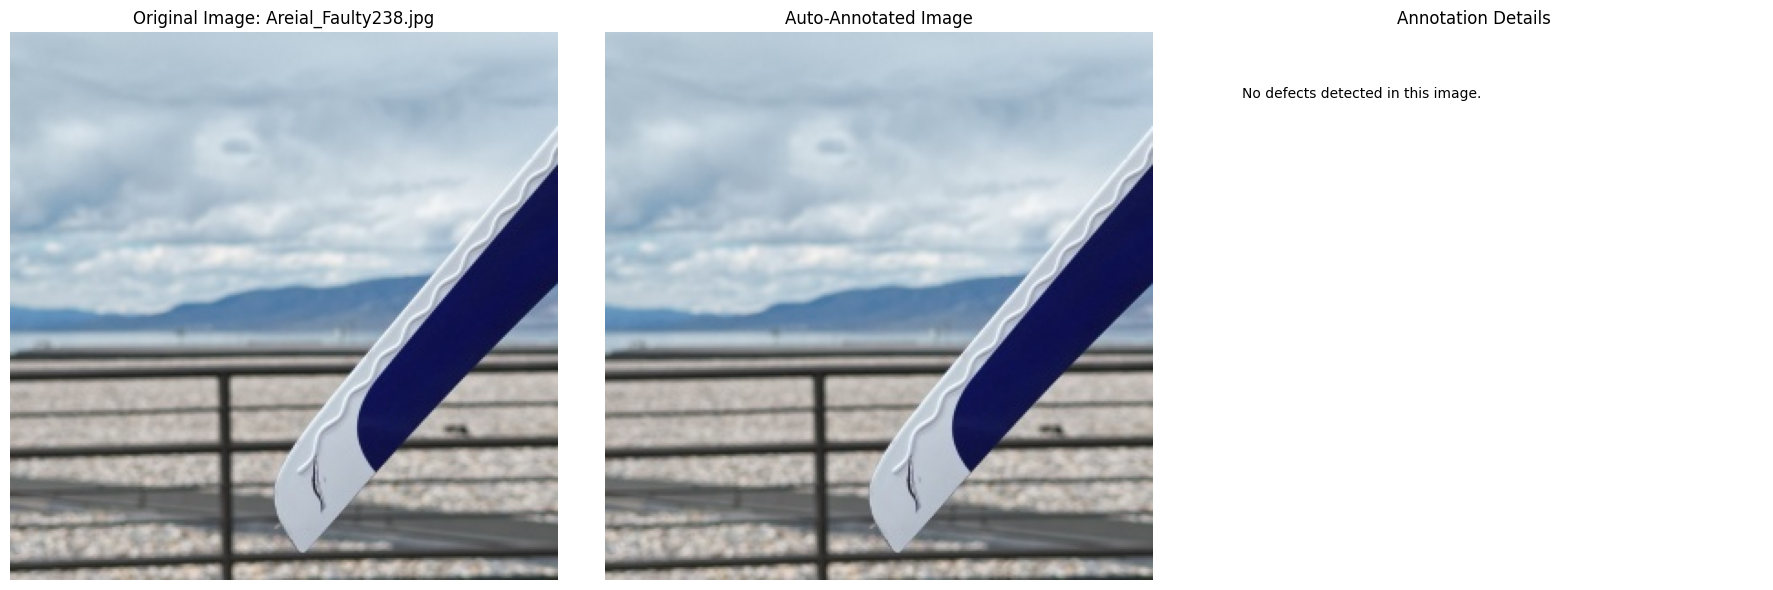


Raw COCO data for Areial_Faulty238.jpg:
Image ID: 34
Image dimensions: 300×300
Annotations: 0




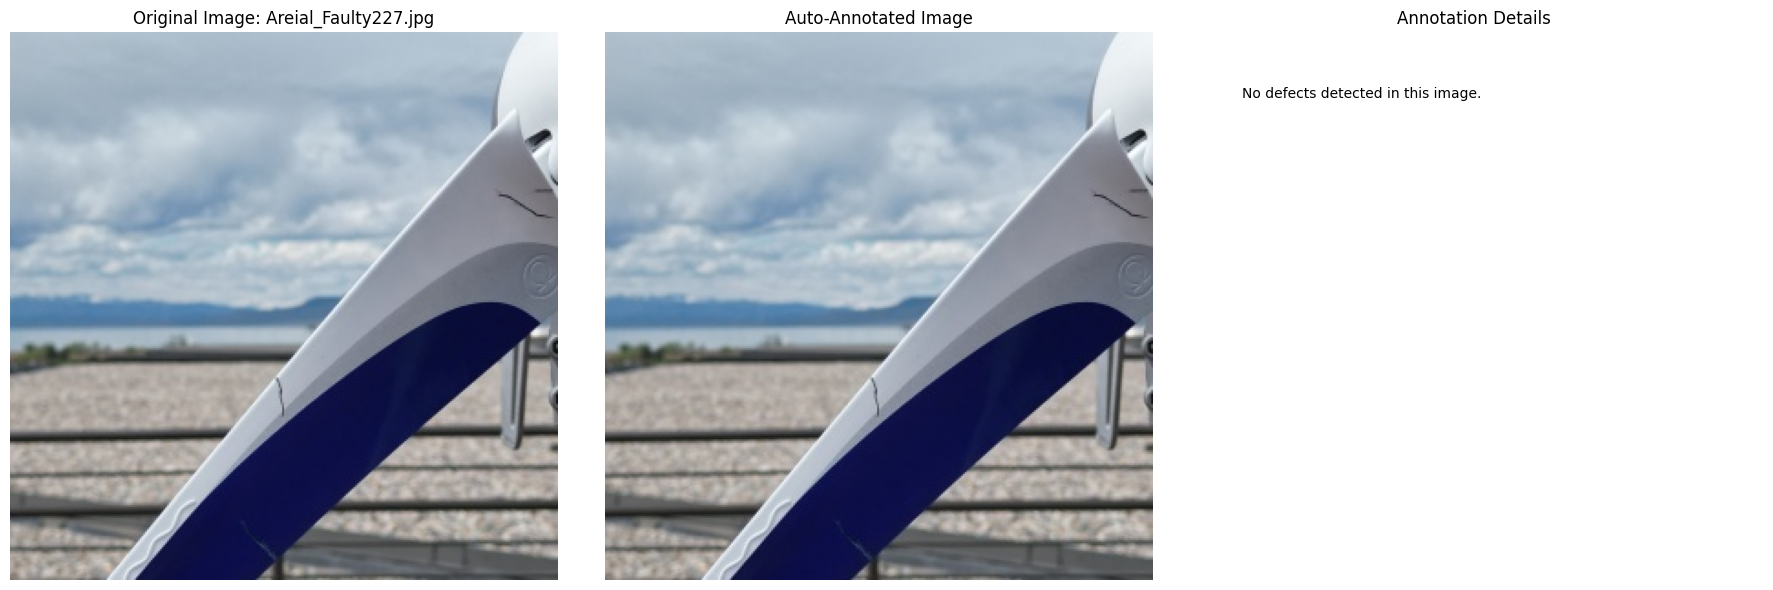


Raw COCO data for Areial_Faulty227.jpg:
Image ID: 32
Image dimensions: 300×300
Annotations: 0




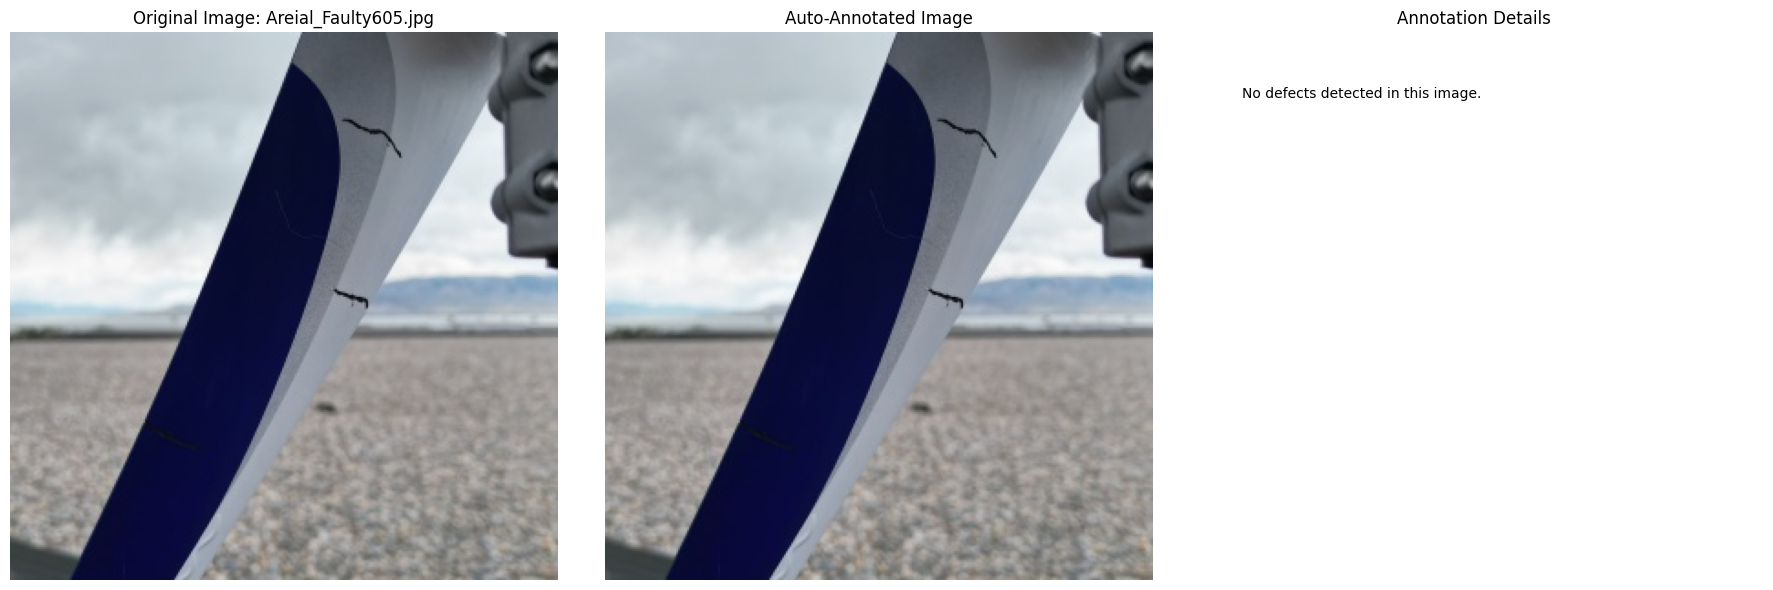


Raw COCO data for Areial_Faulty605.jpg:
Image ID: 98
Image dimensions: 300×300
Annotations: 0




In [2]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
from IPython.display import display, HTML
import random

new_images_dir = "/home/pauloarbu/Faulty_without_annot/selected"  # Directory containing new faulty images
# Use fixed paths instead of user input
annotation_file = "./auto_annotations_20250404_134650/auto_annotations.json"
viz_dir = "./auto_annotations_20250404_134650/visualization"
num_examples = 3  # Number of examples to display

def display_annotations():
    """
    Display examples of auto-annotated images with their annotations
    """
    if not os.path.exists(annotation_file):
        print("ERROR: Annotation file not found:", annotation_file)
        return
    
    if not os.path.exists(viz_dir):
        print("ERROR: Visualization directory not found:", viz_dir)
        return
    
    print(f"Loading annotations from: {annotation_file}")
    
    # Load COCO annotations
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    
    # Build category lookup
    categories = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
    
    # Build image lookup
    image_lookup = {img["id"]: img for img in coco_data["images"]}
    
    # Group annotations by image
    annotations_by_image = {}
    for ann in coco_data["annotations"]:
        image_id = ann["image_id"]
        if image_id not in annotations_by_image:
            annotations_by_image[image_id] = []
        annotations_by_image[image_id].append(ann)
    
    # Get list of images that have visualizations
    viz_files = glob.glob(os.path.join(viz_dir, "viz_*"))
    valid_images = []
    
    for viz_file in viz_files:
        base_name = os.path.basename(viz_file).replace("viz_", "")
        for img in coco_data["images"]:
            if img["file_name"] == base_name:
                valid_images.append((img, viz_file))
    
    if not valid_images:
        print("ERROR: No valid auto-annotated images found!")
        return
    
    # Select random examples
    if len(valid_images) > num_examples:
        examples = random.sample(valid_images, num_examples)
    else:
        examples = valid_images
    
    print(f"Displaying {len(examples)} example(s) of auto-annotated images")
    
    # Display each example
    for i, (img_info, viz_path) in enumerate(examples):
        img_id = img_info["id"]
        filename = img_info["file_name"]
        
        # Get annotations for this image
        annotations = annotations_by_image.get(img_id, [])
        
        # Load visualization image (with bounding boxes)
        viz_img = cv2.imread(viz_path)
        viz_img = cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB)
        
        # Try to find original image
        orig_path = os.path.join(new_images_dir, filename)
        if os.path.exists(orig_path):
            orig_img = cv2.imread(orig_path)
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        else:
            # Create a placeholder
            orig_img = np.zeros_like(viz_img)
            cv2.putText(orig_img, "Original not found", (50, orig_img.shape[0]//2),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        # Create figure
        plt.figure(figsize=(18, 6))
        
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(orig_img)
        plt.title(f"Original Image: {filename}")
        plt.axis('off')
        
        # Plot visualization image
        plt.subplot(1, 3, 2)
        plt.imshow(viz_img)
        plt.title(f"Auto-Annotated Image")
        plt.axis('off')
        
        # Display annotation details
        plt.subplot(1, 3, 3)
        plt.axis('off')
        if annotations:
            annotation_text = f"Found {len(annotations)} defects:\n\n"
            for j, ann in enumerate(annotations):
                cat_id = ann["category_id"]
                cat_name = categories.get(cat_id, f"Unknown ({cat_id})")
                bbox = ann["bbox"]
                score = ann.get("score", "N/A")
                
                annotation_text += f"{j+1}. {cat_name}\n"
                annotation_text += f"   Score: {score:.2f}\n"
                annotation_text += f"   Bbox: [x={bbox[0]:.1f}, y={bbox[1]:.1f}, w={bbox[2]:.1f}, h={bbox[3]:.1f}]\n"
                annotation_text += f"   Area: {ann['area']:.1f} pixels\n\n"
        else:
            annotation_text = "No defects detected in this image."
        
        plt.text(0.1, 0.9, annotation_text, fontsize=10, verticalalignment='top')
        plt.title("Annotation Details")
        
        plt.tight_layout()
        plt.show()
        
        # Print raw COCO JSON for this image
        print(f"\nRaw COCO data for {filename}:")
        print(f"Image ID: {img_id}")
        print(f"Image dimensions: {img_info['width']}×{img_info['height']}")
        print(f"Annotations: {len(annotations)}")
        if annotations:
            print("\nSample annotation JSON:")
            print(json.dumps(annotations[0], indent=2))
        print("\n" + "="*80 + "\n")

# Display examples
display_annotations()